### Installation 

This algorithm requires Theano and Lasagne libraries.

In [1]:
import sys
import os
sys.path.append("engine/")
sys.path.append("funcs/")
sys.setrecursionlimit(10000)

import theano.gpuarray
theano.gpuarray.use('cuda0')

import theano
import theano.tensor as T
from theano import config
import numpy as np
import pickle
import copy
import time
from itertools import *

from RecognitionModel import *
from SV_C import *
from data_funcs import *
from utils import *
from plot_funcs import *

Using cuDNN version 6021 on context None
Preallocating 10986/12207 Mb (0.900000) on cuda0
Mapped name None to device cuda0: GeForce GTX TITAN X (0000:03:00.0)


### Set hyper parameters

In [2]:
''' Dataset 1: OGB '''

params = {}
params['dataset'] = 'real_cai3np_ogb1.pkl'
params['layout'] =  ([35,30,20,10],[31,21,21,11])  # Layout of the CNN (mumber of filter, size of filters)
params['resample_facs'] = [50,[2]]                 # Frequency and resampling factor. i.e. data comes at 50 Hz and needs to be sampled down by a factor of 2 to get to 25 Hz
params['timebins'] =  200                          # Length of trace-snippets in timesteps
params['batchSize'] =  10                          # Number of snippets pet batch
params['buffers'] =  [50,50]                       # Buffer on each side that are not evaluated when taking the gradients. Avoids artifacts due to padded convolutions
params['print_freq'] =  10                         # Every n timesteps the current correlation score is evaluated and the model is saved based on the validation score
params['epochs'] =  50                             # Number of evaluations till training stops
params['lr'] =  4e-4                               # learning rate
params['RecModel'] =  GRU_FB_BernoulliRecognition  # architecture, GRU_FB_BernoulliRecognition uses a stochastic RNN and is able to sample correlated spike trains. BernoulliRecognition is a regular CNN and gives an estimate of the firing rate.

### Load Data

Here we use preprocessed data which is generated in the DataPrep notebook.

In [24]:
with open(params['dataset'], 'rb') as f:
    data = pickle.load(f)

timebins = params['timebins'] + sum(params['buffers'])
resample = params['resample_facs'][0]
facs = params['resample_facs'][1]

Traces_all = data['traces']
Spikes_all = data['spikes']

fps = data['fps']
spikefps = data['spike_fps']

traces_train,traces_val,spikes_train,spikes_val = data_timesplit(Traces_all,Spikes_all,0.7)                         # Data is split in time using 70% for training and 30% for validation
x_train, z_train = data_chop(timebins, traces_train, spikes_train, None, fps, spikefps, resample, superres=1)       # Data is arranged in to snippets for training

test_tr_val, test_sp_val = data_chop(1000, traces_val, spikes_val, None, fps, spikefps, resample, superres=1, fb=False)       # Data is split into bigger snippets for evaluation during training
test_tr_train, test_sp_train = data_chop(1000, traces_train, spikes_train, None, fps, spikefps, resample, superres=1, fb=False)

### Setting up the model and training

In [4]:
recDict = set_rec_net(params['layout'][0], params['layout'][1], superres = 1, AR = 'GRU' in str(params['RecModel']),  n_rnn_units = 128, n_features = 13)
model = SV(recDict, params['RecModel'], params['batchSize'], filename = 'test_run') 

model.set_dataset(test_tr_val, test_sp_val, test_tr_train, test_sp_train)

model.exp_params = params
model.buffers = params['buffers']
model.resample = resample
model.facs = [int(f*model.superres) for f in facs]

x_train = np.expand_dims(np.vstack(x_train),0).astype(config.floatX)
z_train = np.expand_dims(np.vstack(z_train),0).astype(config.floatX)

model.fit(x_train, z_train, max_epochs= params['epochs'], learning_rate = params['lr'], print_output = True, stream_traces = False, print_freq=params['print_freq'])

Corr. Val./Train: 0.380/0.436  || Time upd./Eval.:  267.4 ms 0.9 s  || BatchNr.:  10
Corr. Val./Train: 0.431/0.490  || Time upd./Eval.:  292.9 ms 0.9 s  || BatchNr.:  20
Corr. Val./Train: 0.440/0.500  || Time upd./Eval.:  303.5 ms 1.8 s  || BatchNr.:  30
Corr. Val./Train: 0.438/0.488  || Time upd./Eval.:  291.9 ms 0.4 s  || BatchNr.:  40
Corr. Val./Train: 0.450/0.506  || Time upd./Eval.:  295.9 ms 0.8 s  || BatchNr.:  50
Corr. Val./Train: 0.451/0.506  || Time upd./Eval.:  295.0 ms 0.9 s  || BatchNr.:  60
Corr. Val./Train: 0.453/0.511  || Time upd./Eval.:  293.0 ms 0.9 s  || BatchNr.:  70
Corr. Val./Train: 0.443/0.505  || Time upd./Eval.:  298.6 ms 0.4 s  || BatchNr.:  80
Corr. Val./Train: 0.455/0.511  || Time upd./Eval.:  281.1 ms 0.9 s  || BatchNr.:  90
Corr. Val./Train: 0.458/0.511  || Time upd./Eval.:  298.2 ms 0.9 s  || BatchNr.:  100
Corr. Val./Train: 0.454/0.514  || Time upd./Eval.:  293.9 ms 0.4 s  || BatchNr.:  110
Corr. Val./Train: 0.458/0.511  || Time upd./Eval.:  341.5 ms 1.

In [26]:
with open('test_run.pkl', 'rb') as f:     # Load model with best validation score
    model_best = pickle.load(f)

###  Example plots from cell 1 and 2

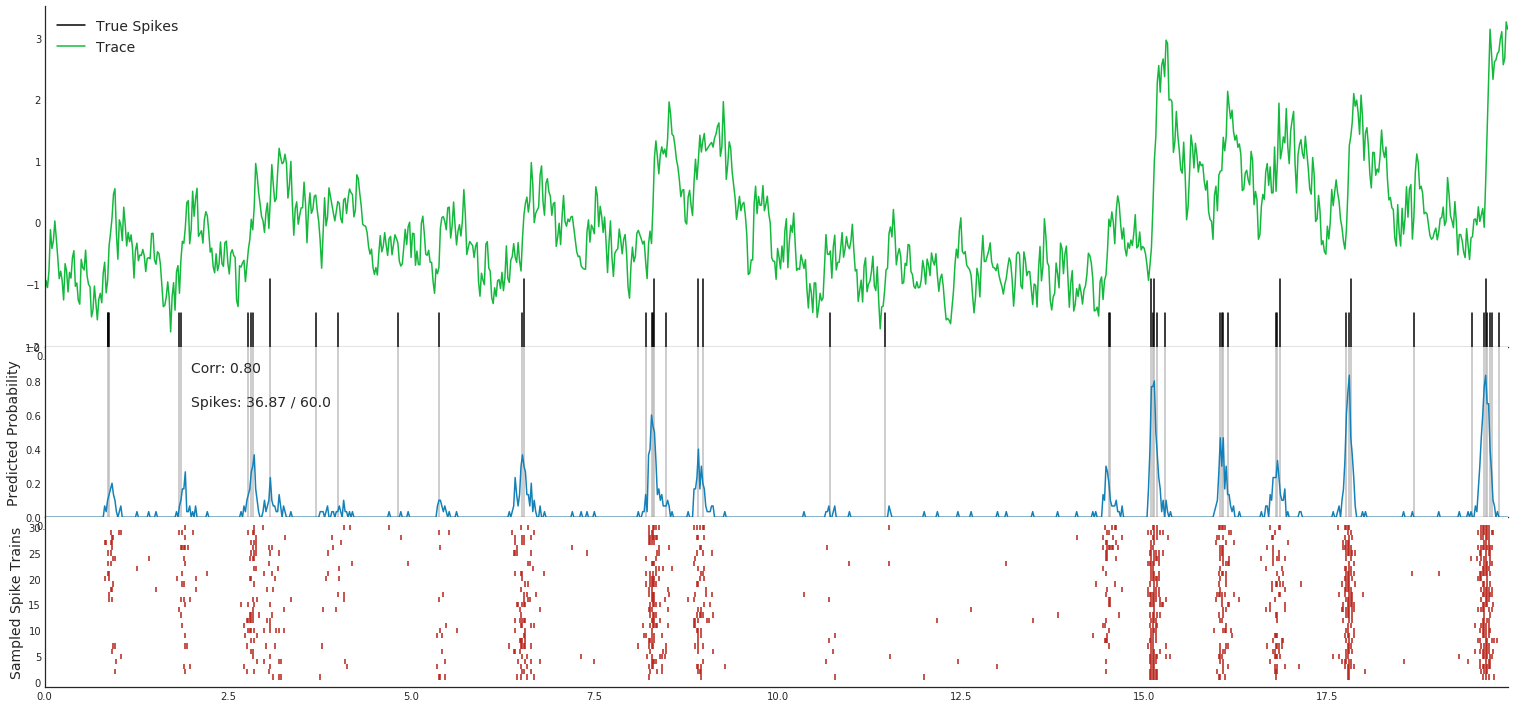

In [6]:
plot_preds_bl(model_best, data, 0)  

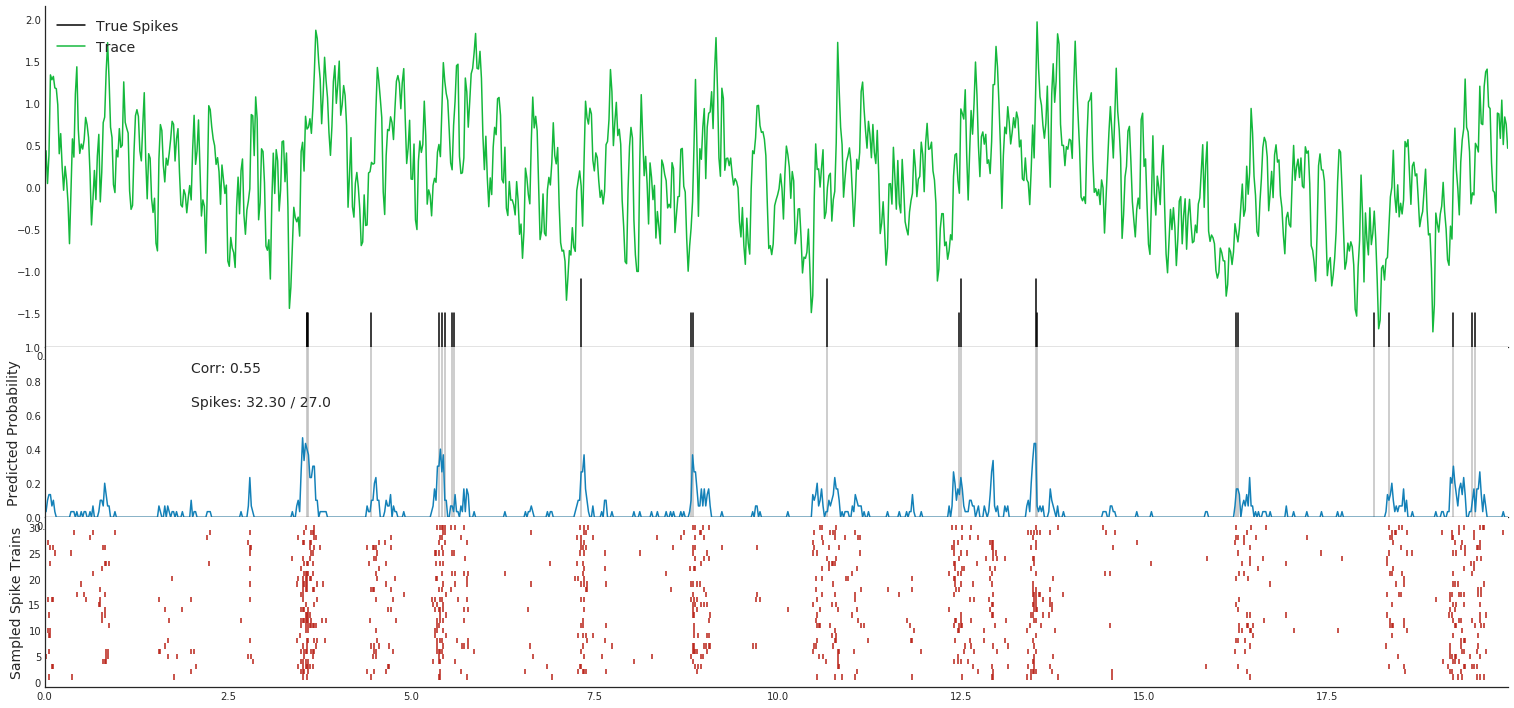

In [7]:
plot_preds_bl(model_best, data, 1)